In [1]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.table import Table, hstack, vstack
from scipy.stats import ks_2samp, beta
from functools import reduce

import math
import mpl_style
import csv
import hex_scatter as hs

H0 = 70.
cosmo = FlatLambdaCDM(H0, Om0=0.3)
h = H0/100

In [4]:
group_table = Table(fits.getdata('../group_table.fits'))

#cell initializing different indices for use later
#group_table indices
pair_ind = np.where(group_table['n_gal'] == 2)[0]
group_ind = np.where(group_table['n_gal'] > 2)[0]

halo_mass_val_ind = np.where(group_table['halo_mass'] > 2)[0]

high_mass_cent_ind = np.where(group_table['cent_mass'] >= 10.5)[0]
low_mass_cent_ind = np.where(group_table['cent_mass'] < 10.5)[0]

sf_cent_ind = np.where(group_table['sfing_central'] == 'SFing')[0]
passive_cent_ind = np.where(group_table['sfing_central'] == 'passive')[0]

red_cent_ind = np.where(group_table['cent_redblue'] == 'red')[0]
blue_cent_ind = np.where(group_table['cent_redblue'] == 'blue')[0]

spiral_cent_ind = np.where(group_table['cent_pfeat'] >= 0.8)[0]
smooth_cent_ind = np.where(group_table['cent_pfeat'] <= 0.2)[0]
int_cent_ind = np.intersect1d(np.where(group_table['cent_pfeat'] < 0.8)[0],np.where(group_table['cent_pfeat'] > 0.2)[0])

spiral_half_cent_ind = np.where(group_table['cent_pfeat'] >= 0.5)[0]
smooth_half_cent_ind = np.where(group_table['cent_pfeat'] < 0.5)[0]

#central morphology/color of groups
redelliptical_cent_ind = np.intersect1d(red_cent_ind, smooth_cent_ind) 
blueelliptical_cent_ind = np.intersect1d(blue_cent_ind, smooth_cent_ind)
redspiral_cent_ind = np.intersect1d(red_cent_ind, spiral_cent_ind)
bluespiral_cent_ind = np.intersect1d(blue_cent_ind, spiral_cent_ind)

In [5]:
## plan: bin galaxies based on halo mass, then compute average

def halo_mass_frac(fracs, hmasses, labels, ylabel): 
    #fracs is a list of arrays for each line to plot with satellite fraction
    #hmasses are the corresponding halo masses for fracs
    f = plt.figure(figsize=(8,8))
    
    colors = ['b', 'r']
    
    all_mass = np.concatenate(hmasses)
    mbins = np.percentile(all_mass, np.arange(0,100,100/6))
    for i in range(len(fracs)): #loop thru arrays in fracs
        mass_hist, b = np.histogram(hmasses[i], density=False, bins=mbins)
        whichmassbin = np.digitize(hmasses[i], mbins[:-1]) #this gives which # mass bin each entry is in
        whichmassbin = whichmassbin - 1
        
        binned_fracs = []
        frac_err = []
        bin_plot_pts = []
        
        for b in range(len(mbins[:-1])): #now loop thru bins to calculate avg fraction for each 
            mass_ind = np.where(whichmassbin == b)[0]
            print(len(mass_ind))
            avg_frac = np.mean(fracs[i][mass_ind])
            y_err = np.std(fracs[i][mass_ind])
            #print(y_err)
            binned_fracs.append(avg_frac)
            frac_err.append(y_err)
            bin_plot_pts.append((mbins[b] + mbins[b+1])/2)
            
        plt.errorbar(bin_plot_pts, binned_fracs, yerr=frac_err, capsize=5, color=colors[i], label=labels[i])
    plt.legend()
    plt.xlabel(r'$\log (M_{halo}/M_{\odot}/h)$')
    plt.ylabel(ylabel)
            

34
24
33
16
16
177
186
179
195
406


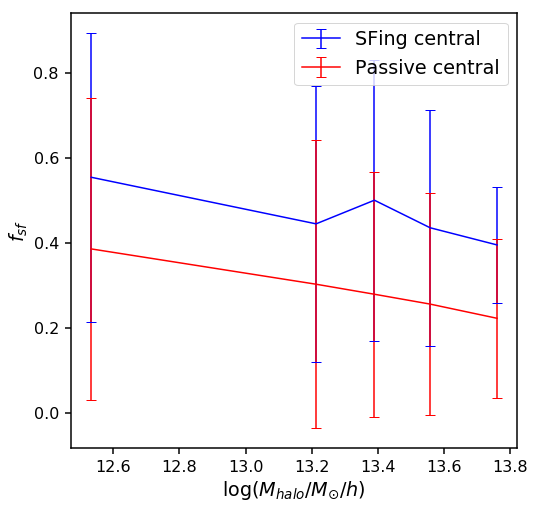

In [51]:
plt.style.use(mpl_style.style1)

sfing_cent_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, sf_cent_ind))
passive_cent_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, passive_cent_ind))

sfing_cent_ssfr_frac = group_table['sat_sf_frac'][sfing_cent_group_ind]
passive_cent_ssfr_frac = group_table['sat_sf_frac'][passive_cent_group_ind]

frac_arrs = [sfing_cent_ssfr_frac, passive_cent_ssfr_frac]

sfing_cent_halo_mass = group_table['halo_mass'][sfing_cent_group_ind]
passive_cent_halo_mass = group_table['halo_mass'][passive_cent_group_ind]

halo_mass_arrs = [sfing_cent_halo_mass, passive_cent_halo_mass]


halo_mass_frac(frac_arrs, halo_mass_arrs, ['SFing central', 'Passive central'], r'$f_{sf}$')

64
58
49
50
57
107
114
121
120
287


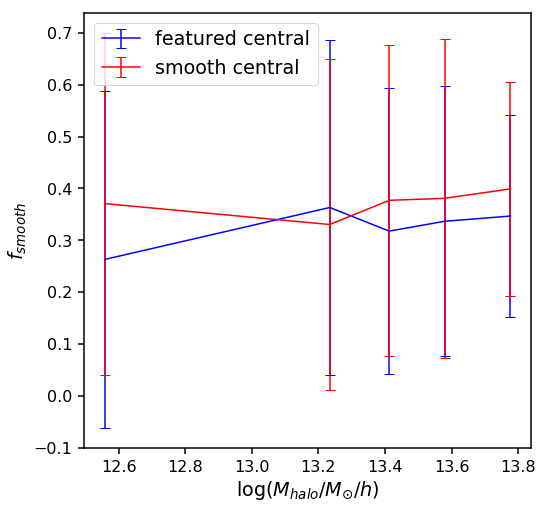

In [52]:
plt.style.use(mpl_style.style1)

spiral_cent_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, spiral_cent_ind))
smooth_cent_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, smooth_cent_ind))

spiral_cent_ssfr_frac = group_table['sat_smooth_frac'][spiral_cent_group_ind]
smooth_cent_ssfr_frac = group_table['sat_smooth_frac'][smooth_cent_group_ind]

frac_arrs = [spiral_cent_ssfr_frac, smooth_cent_ssfr_frac]

spiral_cent_halo_mass = group_table['halo_mass'][spiral_cent_group_ind]
smooth_cent_halo_mass = group_table['halo_mass'][smooth_cent_group_ind]

halo_mass_arrs = [spiral_cent_halo_mass, smooth_cent_halo_mass]

halo_mass_frac(frac_arrs, halo_mass_arrs, ['featured central', 'smooth central'], r'$f_{smooth}$')

64
58
49
50
57
107
114
121
120
287


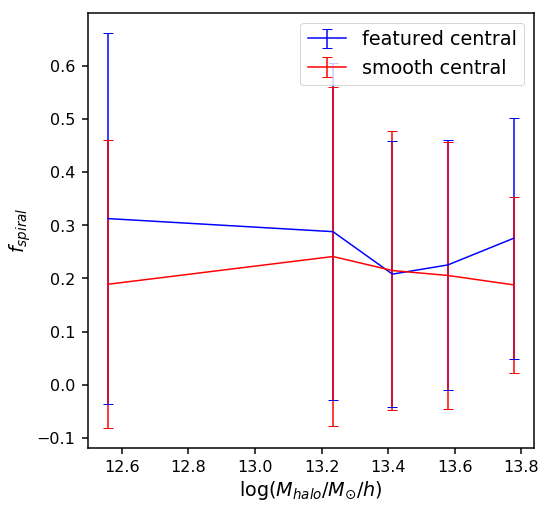

In [53]:
plt.style.use(mpl_style.style1)

spiral_cent_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, spiral_cent_ind))
smooth_cent_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, smooth_cent_ind))

spiral_cent_ssfr_frac = group_table['sat_spiral_frac'][spiral_cent_group_ind]
smooth_cent_ssfr_frac = group_table['sat_spiral_frac'][smooth_cent_group_ind]

frac_arrs = [spiral_cent_ssfr_frac, smooth_cent_ssfr_frac]

spiral_cent_halo_mass = group_table['halo_mass'][spiral_cent_group_ind]
smooth_cent_halo_mass = group_table['halo_mass'][smooth_cent_group_ind]

halo_mass_arrs = [spiral_cent_halo_mass, smooth_cent_halo_mass]

halo_mass_frac(frac_arrs, halo_mass_arrs, ['featured central', 'smooth central'], r'$f_{spiral}$')

80
76
69
64
76
131
134
143
147
346


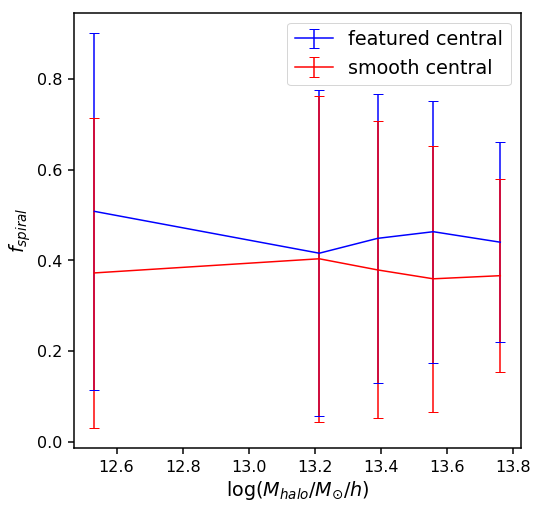

In [54]:
plt.style.use(mpl_style.style1)
##this plot uses the 1/2 fraction criteria

spiral_cent_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, spiral_half_cent_ind))
smooth_cent_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, smooth_half_cent_ind))

spiral_cent_ssfr_frac = group_table['sat_spiral_half_frac'][spiral_cent_group_ind]
smooth_cent_ssfr_frac = group_table['sat_spiral_half_frac'][smooth_cent_group_ind]

frac_arrs = [spiral_cent_ssfr_frac, smooth_cent_ssfr_frac]

spiral_cent_halo_mass = group_table['halo_mass'][spiral_cent_group_ind]
smooth_cent_halo_mass = group_table['halo_mass'][smooth_cent_group_ind]

halo_mass_arrs = [spiral_cent_halo_mass, smooth_cent_halo_mass]

halo_mass_frac(frac_arrs, halo_mass_arrs, ['featured central', 'smooth central'], r'$f_{spiral}$')

25
13
24
15
28
36
48
36
46
94


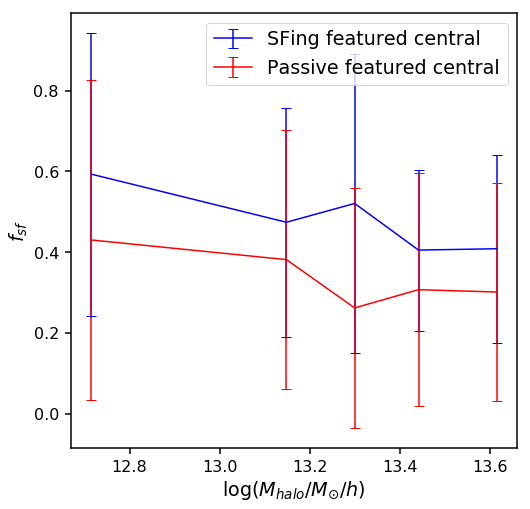

In [9]:
plt.style.use(mpl_style.style1)

sfing_spiral_cent_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, sf_cent_ind, spiral_half_cent_ind))
passive_spiral_cent_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, passive_cent_ind, spiral_half_cent_ind))

sfing_spiral_cent_ssfr_frac = group_table['sat_sf_frac'][sfing_spiral_cent_group_ind]
passive_spiral_cent_ssfr_frac = group_table['sat_sf_frac'][passive_spiral_cent_group_ind]

frac_arrs = [sfing_spiral_cent_ssfr_frac, passive_spiral_cent_ssfr_frac]

sfing_spiral_cent_halo_mass = group_table['halo_mass'][sfing_spiral_cent_group_ind]
passive_spiral_cent_halo_mass = group_table['halo_mass'][passive_spiral_cent_group_ind]

halo_mass_arrs = [sfing_spiral_cent_halo_mass, passive_spiral_cent_halo_mass]


halo_mass_frac(frac_arrs, halo_mass_arrs, ['SFing featured central', 'Passive featured central'], r'$f_{sf}$')

8
4
6
0
0
142
146
144
150
301


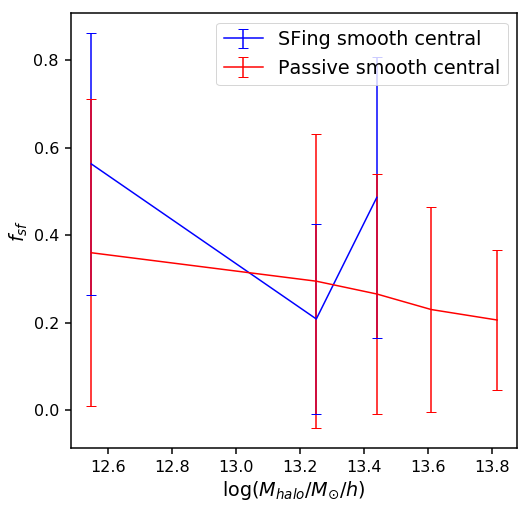

In [8]:
plt.style.use(mpl_style.style1)

sfing_smooth_cent_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, sf_cent_ind, smooth_half_cent_ind))
passive_smooth_cent_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, passive_cent_ind, smooth_half_cent_ind))

sfing_smooth_cent_ssfr_frac = group_table['sat_sf_frac'][sfing_smooth_cent_group_ind]
passive_smooth_cent_ssfr_frac = group_table['sat_sf_frac'][passive_smooth_cent_group_ind]

frac_arrs = [sfing_smooth_cent_ssfr_frac, passive_smooth_cent_ssfr_frac]

sfing_smooth_cent_halo_mass = group_table['halo_mass'][sfing_smooth_cent_group_ind]
passive_smooth_cent_halo_mass = group_table['halo_mass'][passive_smooth_cent_group_ind]

halo_mass_arrs = [sfing_smooth_cent_halo_mass, passive_smooth_cent_halo_mass]


halo_mass_frac(frac_arrs, halo_mass_arrs, ['SFing smooth central', 'Passive smooth central'], r'$f_{sf}$')

16
16
19
16
38
5
4
1
5
3


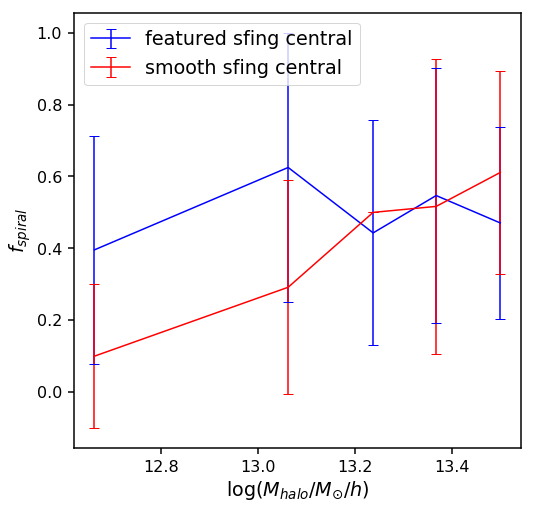

In [11]:
plt.style.use(mpl_style.style1)
##this plot uses the 1/2 fraction criteria

spiral_sfing_cent_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, spiral_half_cent_ind, sf_cent_ind))
smooth_sfing_cent_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, smooth_half_cent_ind, sf_cent_ind))

spiral_sfing_cent_ssfr_frac = group_table['sat_spiral_half_frac'][spiral_sfing_cent_group_ind]
smooth_sfing_cent_ssfr_frac = group_table['sat_spiral_half_frac'][smooth_sfing_cent_group_ind]

frac_arrs = [spiral_sfing_cent_ssfr_frac, smooth_sfing_cent_ssfr_frac]

spiral_sfing_cent_halo_mass = group_table['halo_mass'][spiral_sfing_cent_group_ind]
smooth_sfing_cent_halo_mass = group_table['halo_mass'][smooth_sfing_cent_group_ind]

halo_mass_arrs = [spiral_sfing_cent_halo_mass, smooth_sfing_cent_halo_mass]

halo_mass_frac(frac_arrs, halo_mass_arrs, ['featured sfing central', 'smooth sfing central'], r'$f_{spiral}$')

58
52
50
44
56
133
138
140
147
325


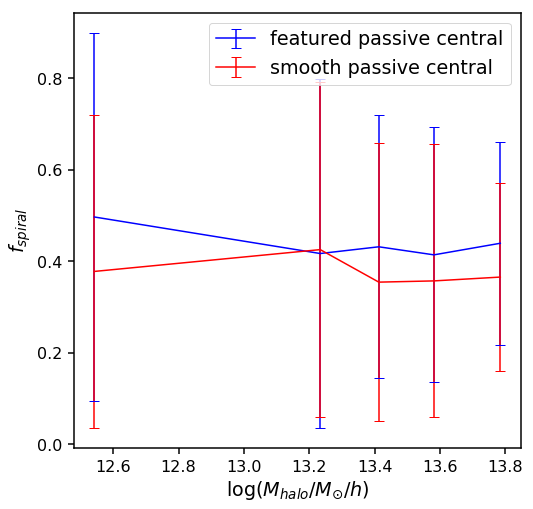

In [12]:
plt.style.use(mpl_style.style1)
##this plot uses the 1/2 fraction criteria
#morphology conformity for 

spiral_passive_cent_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, spiral_half_cent_ind, passive_cent_ind))
smooth_passive_cent_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, smooth_half_cent_ind, passive_cent_ind))

spiral_passive_cent_ssfr_frac = group_table['sat_spiral_half_frac'][spiral_passive_cent_group_ind]
smooth_passive_cent_ssfr_frac = group_table['sat_spiral_half_frac'][smooth_passive_cent_group_ind]

frac_arrs = [spiral_passive_cent_ssfr_frac, smooth_passive_cent_ssfr_frac]

spiral_passive_cent_halo_mass = group_table['halo_mass'][spiral_passive_cent_group_ind]
smooth_passive_cent_halo_mass = group_table['halo_mass'][smooth_passive_cent_group_ind]

halo_mass_arrs = [spiral_passive_cent_halo_mass, smooth_passive_cent_halo_mass]

halo_mass_frac(frac_arrs, halo_mass_arrs, ['featured passive central', 'smooth passive central'], r'$f_{spiral}$')